# Portfolio Machine Learning Trials Without P-Hacking with Honest PSR, DSR, and SPA Tests

<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://www.kaggle.com/code/addarm/portfolio-ml-trials-without-p-hacking"></a>


![Trails and Honesty](https://raw.githubusercontent.com/adamd1985/quant_research/refs/heads/main/images/dont_get_fooled_by_randomness_banner.png)

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->


## Introduction

With the rise of ML and large-scale compute in applied quantitative research, testing many strategies and models concurrently is now standard. These pipelines generate, tune, and select models at scale. In multiple-testing settings, performance metrics should be interpreted as random variables conditioned on the search process, not as standalone estimates selected after the fact.

This article frames Sharpe ratio (SR) inference as statistical governance for model-selection pipelines:
1. Model selection under repeated experimentation with statistical control.
2. Performance inference in high-throughput strategy discovery.

Following Bailey and Lopez de Prado (2012, 2014), it formalizes the sampling distribution of the Sharpe ratio and presents two uncertainty-aware evaluation tools: the Probabilistic Sharpe Ratio (PSR) and the Deflated Sharpe Ratio (DSR), with synthetic examples.


## Notebook Setup
This notebook uses Python with NumPy, pandas, SciPy, and Matplotlib. A fixed seed ensures reproducibility.


In [ ]:
import numpy as np
import pandas as pd
import numpy as np
from numpy.random import default_rng
import yfinance as yf

from scipy.stats import skew, kurtosis, skewnorm, norm
import matplotlib.pyplot as plt
from pprint import pprint
from numpy.typing import NDArray
import numpy as np
from numpy.random import default_rng
import warnings
warnings.filterwarnings("ignore")

INSTALL_DEPS = False
if INSTALL_DEPS:
    # If Kaggle or Colab, you have to manage these. If local, install all
    %pip install numpy
    %pip install pandas
    %pip install scipy
    %pip install yfinance


np.random.seed(444)


## The Sharpe Ratio and Its Sampling Distribution

The Sharpe ratio (SR) is a common benchmark for comparing portfolio and strategy performance. Let returns $r_1,\ldots,r_n$ denote excess returns over the risk-free rate ($r_t - r_f$). The sample SR is defined as the sample mean divided by the sample standard deviation, using $n-1$ degrees of freedom:

$$\widehat{\mathrm{SR}} = \frac{\bar r}{s},$$

where

$$\bar r = \frac{1}{n}\sum_{t=1}^n r_t, \qquad s^2 = \frac{1}{n-1}\sum_{t=1}^n (r_t - \bar r)^2.$$

The Python function below uses a default two-decade mean risk-free rate of $1.5\%$ (annualized) for illustration. PSR and DSR require consistent frequency and are not annualized.


In [2]:
TRADING_DAYS = 252

def compute_sr(returns: np.ndarray[float]) -> float:
    mean_return = np.mean(returns)
    std_return = np.std(returns, ddof=1)
    return mean_return / std_return


Under the assumption of Independent and Identically Distributed (IID) for Normal returns ($\gamma_3 = 0$, $\gamma_4 = 3$), the standard error (SE) of the sample SR is:

$$
\hat\sigma(\widehat{\mathrm{SR}}) =
\sqrt{\frac{1}{n-1}\Bigl(1 + \frac{1}{2}\widehat{\mathrm{SR}}^2\Bigr)}.
$$

The SE shows us that the SR is not a direct property of the strategy, but an attribute of the underlying data, and estimate. Estimated, because Real-world returns aren’t normal. Lo (2002) shows in their paper that the SR estimator is asymptotically normal, and the standard error widens when returns are skewed or fat-tailed:

$$
\hat\sigma(\widehat{\mathrm{SR}}) =
\sqrt{\frac{1}{n-1}\Bigl(
1 + \frac{1}{2}\widehat{\mathrm{SR}}^2
- \gamma_3 \widehat{\mathrm{SR}}
+ \frac{\gamma_4 - 3}{4}\,\widehat{\mathrm{SR}}^2
\Bigr)},
$$

where $\gamma_3$ and $\gamma_4$ are the sample skewness and kurtosis. With that, the usual standardized form is:

$$
\frac{\widehat{\mathrm{SR}} - \mathrm{SR}}{\hat\sigma(\widehat{\mathrm{SR}})}
\xrightarrow{d} \mathcal{N}(0,1).
$$

Therefore, the more skew and fatter tails mean more uncertainty around $\widehat{\mathrm{SR}}$. That’s why it’s better to report uncertainty-adjusted metrics (like PSR/DSR) instead of treating a single SR estimate as a fact. 

High-risk strategies (e.g., crypto strategies) often exhibit negative $\gamma_3$, which increases the variance of the SR estimator and the probability of observing a sizable SR by chance. Without uncertainty adjustment, such estimates can be overstated.

We prepare a few Python helpers for computing these uncertainty metrics. SE formulas are written in terms of population skewness and kurtosis. By default `SciPy` assumes biased moment estimators. To stay consistent with the theory, we correct the bias and switch to a Pearson kurtosis (normal = 3). The code below implements these changes:


In [3]:
def sample_skewness(returns: np.ndarray) -> float:
    return skew(returns, bias=False)

def sample_kurtosis(returns: np.ndarray) -> float:
    return kurtosis(returns, fisher=False, bias=False)

def standard_error_sharpe(sr: float, gamma3: float, gamma4: float, n: int) -> float:
    numerator = 1 + 0.5 * sr ** 2 - gamma3 * sr + (gamma4 - 3) * sr ** 2 / 4
    return np.sqrt(numerator / (n - 1))


## Probabilistic Sharpe Ratio
The Probabilistic Sharpe Ratio (PSR) answers: given a sample Sharpe estimate, what is the probability the true Sharpe exceeds a benchmark $\mathrm{SR}^*$? This treats SR as an estimator with sampling uncertainty (Bailey and Lopez de Prado, 2012). Under asymptotic normality, the probability is

$$\mathrm{PSR}(\mathrm{SR}^*) = \Phi\!\left(\frac{\widehat{\mathrm{SR}} - \mathrm{SR}^*}{\hat\sigma(\widehat{\mathrm{SR}})}\right),$$

where $\Phi$ is the standard normal CDF and $\hat\sigma(\widehat{\mathrm{SR}})$ is the standard error that depends on sample size and the return distribution. Using the skewness/kurtosis-adjusted SE:

$$\widehat{\mathrm{PSR}}(\mathrm{SR}^*) = \Phi\!\left(\frac{(\widehat{\mathrm{SR}} - \mathrm{SR}^*)\sqrt{n-1}}{\sqrt{1 + \frac{1}{2}\widehat{\mathrm{SR}}^2 - \gamma_3\widehat{\mathrm{SR}} + \frac{\gamma_4 - 3}{4}\,\widehat{\mathrm{SR}}^2}}\right).$$

When returns are normal ($\gamma_3 = 0$, $\gamma_4 = 3$), this reduces to the usual SR standard error. For non-normal returns, negative skew and high kurtosis reduce PSR, reflecting lower confidence in the observed SR.

Both the benchmark and the estimated SR must be measured at the same frequency; because PSR is a probability statement, annualization is avoided here.

In model-selection pipelines, PSR provides an uncertainty-aware score that ranks candidates by the likelihood that performance exceeds a target.

To use this, the python function is below:


In [4]:
def compute_psr(sr: float, sr_benchmark: float, gamma3: float, gamma4: float, n: int) -> float:
    se = standard_error_sharpe(sr, gamma3, gamma4, n)
    z = (sr - sr_benchmark) / se
    n = norm.cdf(z)
    return n


The plots below visualize how PSR behaves as sample length, skewness, kurtosis, and the number of trials change.


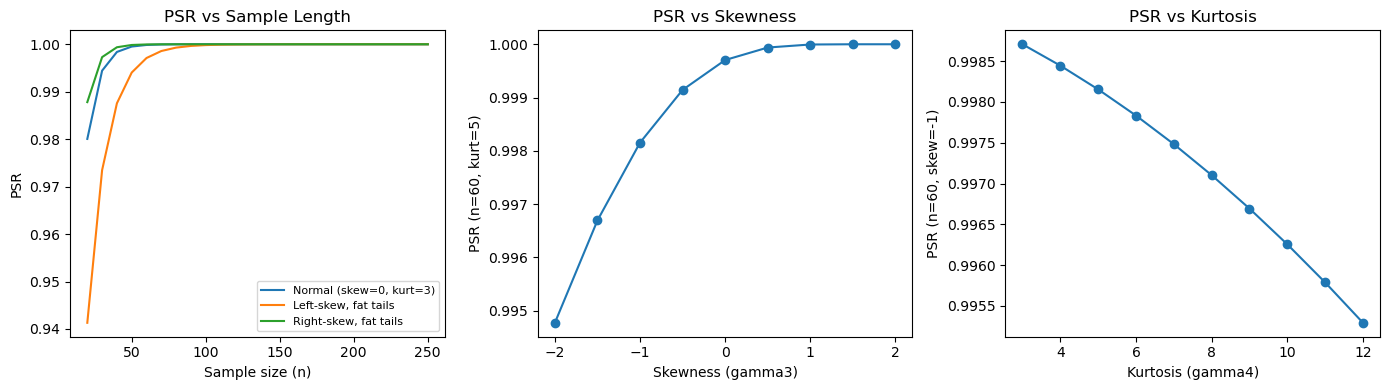

In [5]:
# PSR sensitivity to sample length, skewness, and kurtosis
sr_hat = 0.5
sr_star = 0.0

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1) PSR vs sample length
n_vals = np.arange(20, 260, 10)
profiles = [
    (0.0, 3.0, 'Normal (skew=0, kurt=3)'),
    (-1.0, 8.0, 'Left-skew, fat tails'),
    (1.0, 8.0, 'Right-skew, fat tails'),
]
for g3, g4, label in profiles:
    psr_vals = [compute_psr(sr_hat, sr_star, g3, g4, n) for n in n_vals]
    axes[0].plot(n_vals, psr_vals, label=label)
axes[0].set_title('PSR vs Sample Length')
axes[0].set_xlabel('Sample size (n)')
axes[0].set_ylabel('PSR')
axes[0].legend(fontsize=8)

# 2) PSR vs skewness
skew_vals = np.linspace(-2, 2, 9)
psr_skew = [compute_psr(sr_hat, sr_star, g3, 5.0, 60) for g3 in skew_vals]
axes[1].plot(skew_vals, psr_skew, marker='o')
axes[1].set_title('PSR vs Skewness')
axes[1].set_xlabel('Skewness (gamma3)')
axes[1].set_ylabel('PSR (n=60, kurt=5)')

# 3) PSR vs kurtosis
kurt_vals = np.linspace(3, 12, 10)
psr_kurt = [compute_psr(sr_hat, sr_star, -1.0, g4, 60) for g4 in kurt_vals]
axes[2].plot(kurt_vals, psr_kurt, marker='o')
axes[2].set_title('PSR vs Kurtosis')
axes[2].set_xlabel('Kurtosis (gamma4)')
axes[2].set_ylabel('PSR (n=60, skew=-1)')

plt.tight_layout()
plt.show()


## PSR as a Hypothesis Test
PSR can be interpreted as a one-sided hypothesis test of skill. Define a benchmark Sharpe ratio $\mathrm{SR}^*$ and test:

- $H_0$: $\mathrm{SR} \le \mathrm{SR}^*$ (no skill beyond the benchmark)
- $H_1$: $\mathrm{SR} > \mathrm{SR}^*$

PSR is the probability of exceeding the benchmark under the estimated sampling distribution. At significance level $\alpha$, reject $H_0$ when $\mathrm{PSR} \ge 1-\alpha$.

The example below first checks whether SPY exceeds a zero-skill benchmark ($\mathrm{SR}^* = 0$). It then compares a deliberately random strategy to SPY; the random strategy should fail to reject $H_0$ against the SPY benchmark.


In [ ]:
spy = yf.download('SPY', start='2020-01-01', end='2026-01-01', auto_adjust=True, progress=False).droplevel(1, axis=1)
spy_returns = spy['Close'].pct_change().dropna().to_numpy()

sr_spy = compute_sr(spy_returns)
skew_spy = sample_skewness(spy_returns)
kurt_spy = sample_kurtosis(spy_returns)

alpha = 0.05 # 95% confidence
psr_spy_vs_zero = compute_psr(sr_spy, sr_benchmark=0.0, gamma3=skew_spy, gamma4=kurt_spy, n=len(spy_returns))
reject_spy_vs_zero = psr_spy_vs_zero >= 1 - alpha

# Random strategy (no edge)
np.random.seed(123)
rand_returns = np.random.normal(0.0, np.std(spy_returns, ddof=1), size=len(spy_returns))

sr_rand = compute_sr(rand_returns)
skew_rand = sample_skewness(rand_returns)
kurt_rand = sample_kurtosis(rand_returns)

psr_rand = compute_psr(sr_rand, sr_benchmark=sr_spy, gamma3=skew_rand, gamma4=kurt_rand, n=len(rand_returns))
reject_rand_vs_spy = psr_rand >= 1 - alpha

print(f'SPY SR (daily): {sr_spy:.3f}')
print(f'PSR(SPY > 0): {psr_spy_vs_zero:.3f} | Reject H0 at 5%: {reject_spy_vs_zero}')
print(f'Random SR (daily): {sr_rand:.3f}')
print(f'PSR(random > SPY): {psr_rand:.3f} | Reject H0 at 5%: {reject_rand_vs_spy}')

SPY SR (daily): 0.049
PSR(SPY > 0): 0.969 | Reject H0 at 5%: True
Random SR (daily): -0.008
PSR(random > SPY): 0.015 | Reject H0 at 5%: False


## Comparing Two Strategies with Different Distributional Characteristics

Two synthetic candidate models are constructed with nearly identical sample Sharpe ratios but very different tail behavior. Strategy 1 has left-tail shocks (negative skew, fat tails), while Strategy 2 is right-skewed with lighter tails. Both are rescaled to the same target mean and volatility so the SRs are comparable, then PSR is used to separate them under sampling uncertainty.

For each strategy, daily returns are drawn for $25$ days and the following are computed:

- The sample SR (non-annualized, therefore no $\sqrt{252}$)
- Skewness and kurtosis of returns
- The Probabilistic Sharpe Ratio relative to a zero benchmark (probability that the true Sharpe ratio is positive)

A long track record (10 years of observations) is also simulated from the same distributions to approximate the true Sharpe ratio for each strategy.

The code below uses fixed parameters chosen to produce similar short-term SRs; rerun if a closer match is desired:


In [7]:
# Strategy 1
mean1 = 0.05            # mean return = 0.25%
std1 = 0.05             # volatility = 0.2%
skew1_param = -8        # negative skew

# Strategy 2
mean2 = 0.05            # mean return = 0.25%
std2 = 0.05             # same volatility
skew2_param = 8         # positive skew

def generate_skewed_returns(skew_param, mean, std, size, add_tail_risk=False):
    data = skewnorm.rvs(a=skew_param, size=size)
    data = (data - np.mean(data)) / np.std(data, ddof=1)
    returns = mean + std * data

    if add_tail_risk:
        # Inject 1-2 left-tail shocks at -20%
        n_shocks = np.random.randint(0, max(1, int(size * 0.01)))
        shock_idx = np.random.choice(size, size=n_shocks, replace=False)
        returns[shock_idx] = np.random.uniform(-0.35, -0.1, size=n_shocks)

    return returns

SAMPLE_DAYS = 55
BM_SR = 0.5

returns1 = generate_skewed_returns(skew1_param, mean1, std1, SAMPLE_DAYS, add_tail_risk=True)
returns2 = generate_skewed_returns(skew2_param, mean2, std2, SAMPLE_DAYS)
sr1 = compute_sr(returns1)
sr2 = compute_sr(returns2)

skew1 = sample_skewness(returns1)
kurt1 = sample_kurtosis(returns1)

skew2 = sample_skewness(returns2)
kurt2 = sample_kurtosis(returns2)

psr1 = compute_psr(sr1, sr_benchmark=BM_SR, gamma3=skew1, gamma4=kurt1, n=SAMPLE_DAYS)
psr2 = compute_psr(sr2, sr_benchmark=BM_SR, gamma3=skew2, gamma4=kurt2, n=SAMPLE_DAYS)

long_returns1 = generate_skewed_returns(skew1_param, mean1, std1, TRADING_DAYS * 4, add_tail_risk=True)
long_returns2 = generate_skewed_returns(skew2_param, mean2, std2, TRADING_DAYS * 4)
true_sr1 = compute_sr(long_returns1)
true_sr2 = compute_sr(long_returns2)

perf_summary = pd.DataFrame({
    'Strategy': ['Strategy 1', 'Strategy 2'],
    'Sample_SR': [sr1, sr2],
    'Skewness': [skew1, skew2],
    'Kurtosis': [kurt1, kurt2],
    'PSR (SR* = 0)': [psr1, psr2],
    'Approx. True_SR': [true_sr1, true_sr2]
})

pprint(perf_summary.round(4))


     Strategy  Sample_SR  Skewness  Kurtosis  PSR (SR* = 0)  Approx. True_SR
0  Strategy 1        1.0   -0.6448    2.6551         0.9948           0.8823
1  Strategy 2        1.0    0.5758    2.7608         1.0000           1.0000


The plots below show the results compared across the strategies:


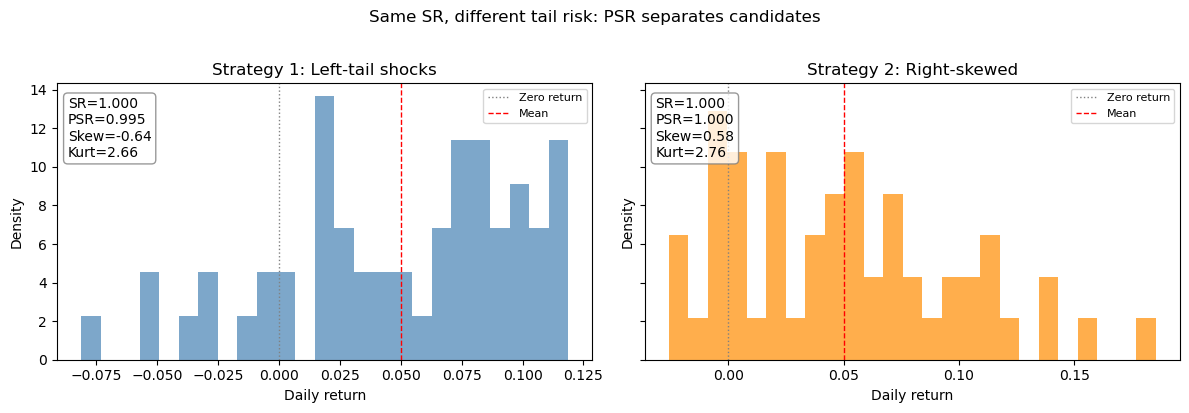

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plot_data = [
    ('Strategy 1: Left-tail shocks', returns1, sr1, psr1, skew1, kurt1, 'steelblue'),
    ('Strategy 2: Right-skewed', returns2, sr2, psr2, skew2, kurt2, 'darkorange')
]

for ax, (title, data, sr, psr, skew_v, kurt_v, color) in zip(axes, plot_data):
    ax.hist(data, bins=25, density=True, color=color, alpha=0.7)
    ax.axvline(0.0, color='gray', linestyle=':', linewidth=1, label='Zero return')
    ax.axvline(np.mean(data), color='red', linestyle='--', linewidth=1, label='Mean')
    ax.set_title(title)
    ax.set_xlabel('Daily return')
    ax.set_ylabel('Density')
    stats_text = f"SR={sr:.3f}\nPSR={psr:.3f}\nSkew={skew_v:.2f}\nKurt={kurt_v:.2f}"

    ax.text(
        0.02, 0.95, stats_text,
        transform=ax.transAxes, va='top', ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
    )
    ax.legend(loc='upper right', fontsize=8)

fig.suptitle('Same SR, different tail risk: PSR separates candidates', y=1.02)
plt.tight_layout()
plt.show()

Strategy 1 exhibits negative skewness, while Strategy 2 is positively skewed; their kurtosis values differ due to sampling variation. Although the sample SR of Strategy 1 may appear attractive, its PSR (relative to a zero benchmark) can be lower than that of Strategy 2.

The PSR explicitly accounts for the sampling variability of $\widehat{\mathrm{SR}}$, which increases with negative skewness and fat tails. 


Even with only $252$ observations, Strategy 2 can provide a higher probability that the true Sharpe ratio will be positive in the future. The long-run SR ratios (computed across 10 years) help approximate the true ordering of the strategies.


## Multiple Testing and Selection Bias
Quantitative and ML research often evaluates many candidate models on the same dataset via hyperparameter optimization, feature search, and automated strategy generation. As the number of trials increases, the probability of observing at least one high SR from sampling variation rises sharply. Bailey and Lopez de Prado (2014) emphasize that selection bias and in-sample overfitting inflate reported performance unless the full search process is accounted for.

A naive out-of-sample test does not resolve this issue because it ignores the size of the search. The expected maximum SR among $N$ independent trials can be large even when the true SR is zero. This motivates the Deflated Sharpe Ratio (DSR), which corrects PSR for multiple testing in model selection pipelines.


## Deflated Sharpe Ratio (DSR)

The DSR adjusts PSR for the number of trials (Bailey and Lopez de Prado, 2014). Suppose $M$ strategies are tested and are not fully independent. The effective number of independent trials is estimated as

$$N \approx \hat{\rho} + (1 - \hat{\rho}) M,$$

where $\hat{\rho}$ is the average pairwise correlation among the strategies.

Let $\widehat{\mathrm{SR}}_1,\ldots,\widehat{\mathrm{SR}}_M$ be the Sharpe ratios of the trials. Denote by $E[\widehat{\mathrm{SR}}]$ and $V[\widehat{\mathrm{SR}}]$ their mean and variance. The expected maximum SR after $N$ independent trials is approximated by

$$E\Big[\max\{\widehat{\mathrm{SR}}_n\}\Big] \approx E[\widehat{\mathrm{SR}}] + \sqrt{V[\widehat{\mathrm{SR}}]}\Big[(1 - \gamma)\, \Phi^{-1}(1 - 1/N) + \gamma\, \Phi^{-1}(1 - e^{-1}/N)\Big],$$

where $\gamma \approx 0.5772$ is the Euler-Mascheroni constant. Denote this quantity by $\widehat{\mathrm{SR}}_0$.

The DSR of the best strategy is the PSR computed relative to $\widehat{\mathrm{SR}}_0$:

$$\widehat{\mathrm{DSR}} = \Phi\!\left(\frac{\widehat{\mathrm{SR}} - \widehat{\mathrm{SR}}_0}{\hat\sigma(\widehat{\mathrm{SR}})}\right).$$

A high DSR indicates that the observed Sharpe ratio is unlikely to have arisen by chance given the number of trials and the return distribution.

The Deflated Sharpe Ratio directly addresses the statistical distortion induced by hyperparameter tuning, feature selection, and automated strategy generation. It conditions performance inference on the size and dependence structure of the search space explored by an AutoML pipeline, analogous to a multiple-hypothesis correction in large-scale ML experimentation.

The helper functions below implement the DSR components.


In [9]:
def approx_expected_sr(mean_sr: float, var_sr: float, num_independent: int) -> float:
    # Euler–Mascheroni constant
    gamma_const = 0.5772156649015328606

    term1 = (1 - gamma_const) * norm.ppf(1 - 1 / num_independent)
    term2 = gamma_const * norm.ppf(1 - np.exp(-1) / num_independent)
    return mean_sr + np.sqrt(var_sr) * (term1 + term2)


def compute_effective_trials(correlation_matrix: np.ndarray) -> float:
    m = correlation_matrix.shape[0]
    # Average of off-diagonal correlations
    upper_tri_indices = np.triu_indices(m, k=1)
    avg_corr = correlation_matrix[upper_tri_indices].mean()
    return avg_corr + (1 - avg_corr) * m


def compute_dsr(best_sr: float, gamma3: float, gamma4: float, n: int, sr_array: np.ndarray, correlation_matrix: np.ndarray) -> float:

    N_eff = compute_effective_trials(correlation_matrix)

    mean_sr = np.mean(sr_array)
    var_sr = np.var(sr_array, ddof=1)

    sr0 = approx_expected_sr(mean_sr, var_sr, int(max(1, round(N_eff))))
    se = standard_error_sharpe(best_sr, gamma3, gamma4, n)
    z = (best_sr - sr0) / se

    return norm.cdf(z)


Here is a second experiment. Suppose a researcher runs many trials with no true edge and then cherry-picks the best Sharpe ratio. How can we validate whether that top result reflects skill or just selection bias?

The DSR example below shows how the correction deflates the best-looking SR once we account for the size of the search.


In [10]:
# Cherry-picking simulation: many trials, no edge
np.random.seed(321)
num_trials = 2000
num_days = 252 * 2
sigma = 0.01

trial_returns = np.random.normal(0.0, sigma, size=(num_trials, num_days))
sr_trials = np.array([compute_sr(trial_returns[i]) for i in range(num_trials)])
best_idx = np.argmax(sr_trials)
best_returns = trial_returns[best_idx]
best_sr = sr_trials[best_idx]

best_skew = sample_skewness(best_returns)
best_kurt = sample_kurtosis(best_returns)

psr_best = compute_psr(best_sr, sr_benchmark=0.0, gamma3=best_skew, gamma4=best_kurt, n=num_days)

corr_matrix = np.eye(num_trials)
dsr_best = compute_dsr(best_sr, gamma3=best_skew, gamma4=best_kurt, n=num_days,
                     sr_array=sr_trials, correlation_matrix=corr_matrix)

sr0 = approx_expected_sr(sr_trials.mean(), sr_trials.var(ddof=1), num_trials)

cherry_summary = {
    'Trials': num_trials,
    'Best SR': best_sr,
    'Expected Max SR (SR0)': sr0,
    'PSR (SR* = 0)': psr_best,
    'DSR': dsr_best,
}

pprint(cherry_summary)

{'Best SR': np.float64(0.15314250237141813),
 'DSR': np.float64(0.48519277457218823),
 'Expected Max SR (SR0)': np.float64(0.15477653487478965),
 'PSR (SR* = 0)': np.float64(0.9997486864529994),
 'Trials': 2000}


In this run, the best SR was ~0.153 while the expected maximum SR under the null was ~0.155. That is exactly what one would anticipate from 2,000 no-edge trials. PSR relative to zero is near 1 because even a small positive SR looks statistically convincing with enough observations. But DSR falls to ~0.49 once the search is accounted for, indicating the cherry-picked result is not statistically meaningful.


As we did in our PSR, the plots below show how a DSR evolves on incremental trails:

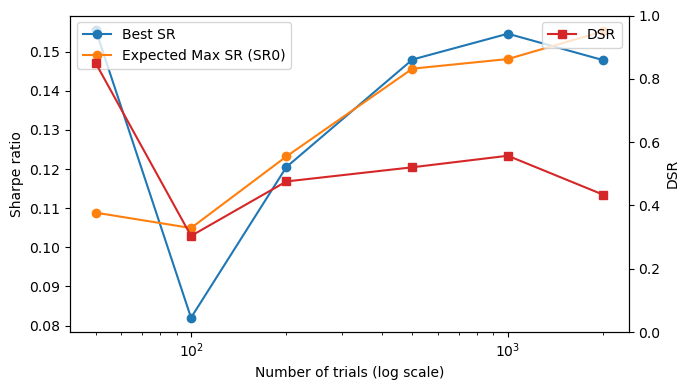

In [15]:
# DSR sensitivity to number of trials (cherry-picking pressure)
np.random.seed(7)
num_days = TRADING_DAYS * 2
sigma = 0.01
trial_counts = [50, 100, 200, 500, 1000, 2000]

best_srs = []
sr0_vals = []
dsr_vals = []

for m in trial_counts:
    trial_returns = np.random.normal(0.0, sigma, size=(m, num_days))
    sr_trials = np.array([compute_sr(trial_returns[i]) for i in range(m)])
    best_idx = np.argmax(sr_trials)
    best_returns = trial_returns[best_idx]
    best_sr = sr_trials[best_idx]

    best_skew = sample_skewness(best_returns)
    best_kurt = sample_kurtosis(best_returns)

    corr_matrix = np.eye(m)
    dsr = compute_dsr(best_sr, gamma3=best_skew, gamma4=best_kurt, n=num_days,
                     sr_array=sr_trials, correlation_matrix=corr_matrix)
    sr0 = approx_expected_sr(sr_trials.mean(), sr_trials.var(ddof=1), m)

    best_srs.append(best_sr)
    sr0_vals.append(sr0)
    dsr_vals.append(dsr)

fig, ax1 = plt.subplots(figsize=(7, 4))
ax1.plot(trial_counts, best_srs, marker='o', label='Best SR')
ax1.plot(trial_counts, sr0_vals, marker='o', label='Expected Max SR (SR0)')
ax1.set_xscale('log')
ax1.set_xlabel('Number of trials (log scale)')
ax1.set_ylabel('Sharpe ratio')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(trial_counts, dsr_vals, color='tab:red', marker='s', label='DSR')
ax2.set_ylabel('DSR')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


These PSR panels highlight three effects: PSR rises with sample length; negative skewness lowers PSR at fixed SR; and higher kurtosis reduces PSR because tail risk increases estimator variance. The DSR plot shows that as the number of trials grows, the expected maximum SR rises even under a no-edge process, while DSR declines toward neutrality, signaling cherry-picking pressure.


## Superior Predictive Ability (SPA) and Data-Snooping
Hansen (2005) proposes the SPA test to address data-snooping when many models are compared to a benchmark. The test evaluates whether any candidate delivers lower expected loss than the benchmark by using studentized loss differentials and a sample-dependent null with a bootstrap-based p-value. This design improves power and reduces sensitivity to poor or irrelevant alternatives.

SPA is complementary to PSR and DSR. While PSR and DSR operate at the level of individual candidate models, SPA operates at the level of the entire model-selection pipeline. It tests whether the search process has discovered genuine predictive ability relative to a benchmark, rather than a lucky outlier.


### SPA Test Statistic (Hansen, 2005)
Let $L(\cdot)$ be a loss function (e.g., squared error). For model $k$ and benchmark $\mathrm{BM}$, define the loss differential

$$d_{k,t} = L(y_t, \hat y_{t|t-1}^{\mathrm{BM}}) - L(y_t, \hat y_{t|t-1}^{k}).$$

The null for superior predictive ability is

$$H_0: \max_k E[d_{k,t}] \le 0,$$

which states that no model has lower expected loss than the benchmark. Hansen proposes a studentized max statistic and a sample-dependent null:

$$T_n^{\mathrm{SPA}} = \max_k \frac{\sqrt{n}\,\bar d_k}{\hat\omega_k},$$

with a null centered at $\hat\mu_{c,k} = \bar d_k\,\mathbf{1}\{ \sqrt{n}\,\bar d_k/\hat\omega_k \ge -\sqrt{2\log\log n} \}$. This down-weights poorly performing models in the null distribution.

The p-value is obtained by a stationary bootstrap of the loss differentials, recentered to the sample-dependent null before recomputing $T_n^{\mathrm{SPA}}$.

The code components in python for computing the SPA are below:


In [16]:
def long_run_variance(x: np.ndarray, lag: int) -> float:
    x = x - x.mean()
    n = len(x)
    gamma0 = np.dot(x, x) / n
    var = gamma0
    for l in range(1, lag + 1):
        gamma = np.dot(x[l:], x[:-l]) / n
        weight = 1 - l / (lag + 1)
        var += 2 * weight * gamma
    return var

def stationary_bootstrap_indices(n: int, p: float, rng: np.random.Generator) -> np.ndarray:
    indices = []
    while len(indices) < n:
        start = rng.integers(0, n)
        block = []
        while True:
            block.append(start)
            if rng.random() < p or len(indices) + len(block) >= n:
                break
            start = (start + 1) % n
        indices.extend(block)
    return np.array(indices[:n])

def spa_test_hansen(loss_bm: np.ndarray, loss_alt: np.ndarray, lag: int = 5, p: float = 0.1, B: int = 300, seed: int = 0):
    # Hansen (2005) SPA test with student max statistic and sample-dependent null.

    n = loss_bm.shape[0]
    if n <= np.exp(np.e):
        raise ValueError('n too small for log log n in SPA; increase sample size or use a different test.')
    d = loss_bm - loss_alt  # shape (m, n)
    dbar = d.mean(axis=1)
    omega2 = np.array([long_run_variance(dk, lag) for dk in d])
    omega = np.sqrt(omega2)

    # Sample-dependent null center
    a_n = np.sqrt(2 * np.log(np.log(n)))
    t_stats = np.sqrt(n) * dbar / omega
    mu_c = dbar * (t_stats >= -a_n)

    stat = np.max(t_stats)

    rng = default_rng(seed)
    stats = []
    for _ in range(B):
        idx = stationary_bootstrap_indices(n, p, rng)
        d_star = d[:, idx]
        dbar_star = d_star.mean(axis=1)

        # Recenter to the sample
        dbar_star_c = dbar_star - dbar + mu_c
        stat_star = np.max(np.sqrt(n) * dbar_star_c / omega)
        stats.append(stat_star)
    pval = np.mean(np.array(stats) > stat)
    return stat, pval

# Synthetic example: benchmark vs. 10 alternatives
n = 252 * 2
m = 10
rng = default_rng(123)
eps_bm = rng.normal(0, 1, n)
loss_bm = eps_bm ** 2

loss_alt = []
for k in range(m):
    scale = 0.98 if k < m // 3 else 1.0  # a few slightly better models
    eps = rng.normal(0, scale, n)
    loss_alt.append(eps ** 2)
loss_alt = np.array(loss_alt)

stat, pval = spa_test_hansen(loss_bm, loss_alt, lag=5, p=0.1, B=300, seed=42)
stat, pval



(np.float64(0.9003861740121412), np.float64(0.74))

In this synthetic run, the SPA statistic is about 0.90 and the p-value is about 0.74, so the null that the benchmark is not inferior to any alternative is not rejected. This is expected because most alternatives are random and only a few are marginally better by construction; SPA accounts for the multiple-comparison setting and does not overstate significance.


The histogram below shows the distribution of SPA p-values under a pure null (no edge) and a mild alternative. Under the null, p-values are closer to uniform; under the alternative, they shift toward smaller values:


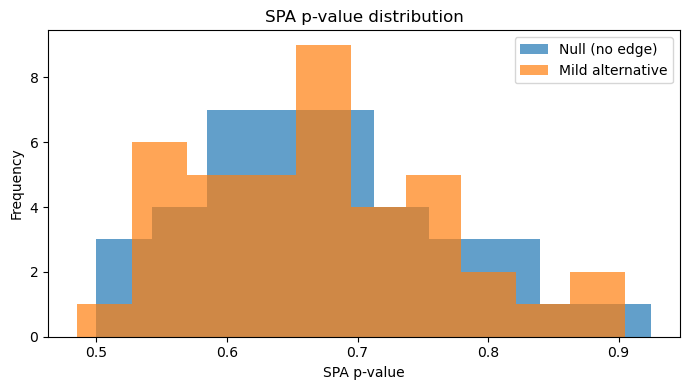

In [17]:
def spa_pvals_sim(num_runs: int, alt: bool) -> np.ndarray:
    pvals = []
    for r in range(num_runs):
        n = TRADING_DAYS * 2
        m = 10
        rng = default_rng(1000 + r)
        eps_bm = rng.normal(0, 1, n)
        loss_bm = eps_bm ** 2

        loss_alt = []
        for k in range(m):
            scale = 1.0
            if alt and k < m // 3:
                scale = 0.98
            eps = rng.normal(0, scale, n)
            loss_alt.append(eps ** 2)
        loss_alt = np.array(loss_alt)

        _, pval = spa_test_hansen(loss_bm, loss_alt, lag=5, p=0.1, B=200, seed=42)
        pvals.append(pval)
    return np.array(pvals)

null_pvals = spa_pvals_sim(40, alt=False)
alt_pvals = spa_pvals_sim(40, alt=True)

plt.figure(figsize=(7, 4))
plt.hist(null_pvals, bins=10, alpha=0.7, label='Null (no edge)')
plt.hist(alt_pvals, bins=10, alpha=0.7, label='Mild alternative')
plt.xlabel('SPA p-value')
plt.ylabel('Frequency')
plt.title('SPA p-value distribution')
plt.legend()
plt.tight_layout()
plt.show()


Under the null, SPA p-values are roughly uniform. Under a mild alternative, the distribution shifts toward smaller p-values, indicating greater evidence against the benchmark. This visualization makes clear why a single p-value should be interpreted in the context of multiple comparisons.


In [18]:
num_assets = 5
num_days = TRADING_DAYS * 2  # two years of daily data (~252 trading days per year)
num_strategies = 500         # number of random in-sample evaluations

# Generate synthetic asset returns: multivariate normal with small mean and covariance
asset_means = np.zeros(num_assets)
cov_matrix = 0.05 ** 2 * (0.2 * np.ones((num_assets, num_assets)) + 0.8 * np.eye(num_assets))
asset_returns = np.random.multivariate_normal(mean=asset_means, cov=cov_matrix, size=num_days)

# Create strategies: for each day, assign random weights that sum to 1
strategies_returns = np.zeros((num_strategies, num_days))
for i in range(num_strategies):
    weights = np.random.dirichlet(alpha=np.ones(num_assets), size=num_days)
    strategies_returns[i] = np.sum(weights * asset_returns, axis=1)

sr_array = np.array([compute_sr(strategies_returns[i]) for i in range(num_strategies)])

best_idx = np.argmax(sr_array)
best_returns = strategies_returns[best_idx]
best_sr = sr_array[best_idx]

best_skew = sample_skewness(best_returns)
best_kurt = sample_kurtosis(best_returns)

# Compute PSR and DSR of best strat.
n_best = len(best_returns)
psr_best = compute_psr(best_sr, sr_benchmark=0.0, gamma3=best_skew, gamma4=best_kurt, n=n_best)
corr_matrix = np.corrcoef(strategies_returns)
dsr_best = compute_dsr(best_sr, gamma3=best_skew, gamma4=best_kurt,
                       n=n_best, sr_array=sr_array, correlation_matrix=corr_matrix)

# SPA test: do any models beat a zero-skill benchmark?

benchmark_returns = np.zeros(num_days)
loss_bm = -benchmark_returns
loss_alt = -strategies_returns
spa_stat, spa_pval = spa_test_hansen(loss_bm, loss_alt, lag=5, p=0.1, B=300, seed=42)

multi_summary = {
    'Best Strategy Index': best_idx,
    'Best Sharpe Ratio': best_sr,
    'Skewness': best_skew,
    'Kurtosis': best_kurt,
    'PSR (SR* = 0)': psr_best,
    'DSR': dsr_best,
    'SPA p-value': spa_pval,
    'Mean SR across strategies': sr_array.mean(),
    'Std SR across strategies': sr_array.std(ddof=1)
}

pprint(multi_summary)

{'Best Sharpe Ratio': np.float64(0.09112707241217795),
 'Best Strategy Index': np.int64(62),
 'DSR': np.float64(0.5480225642102554),
 'Kurtosis': np.float64(2.6690366654548714),
 'Mean SR across strategies': np.float64(0.03187317539799506),
 'PSR (SR* = 0)': np.float64(0.9799997323515471),
 'SPA p-value': np.float64(0.78),
 'Skewness': np.float64(0.1443760877843137),
 'Std SR across strategies': np.float64(0.020872060019412622)}


In our run, the best SR is ~0.091, which looks decent relative to the average SR (~0.019). PSR is high (≈0.98) because the best model has a positive SR and a reasonably long sample. However, DSR drops to ~0.63 once we condition on the size of the search and the dispersion of SRs across trials. The SPA p-value (~0.78) also fails to reject the null that no model beats the benchmark. Together, these suggest the apparent winner is consistent with selection bias rather than genuine edge.


## Conclusion 

This concludes our experiments on portfolio ML trials using PSR and DSR, with SPA as a final safeguard. These techniques move beyond SR as a sufficient descriptor of model quality by addressing statistical reliability, not economic robustness or financial significance.

The Sharpe Ratio is an estimator. Its standard error depends on sample size, skewness, and kurtosis. PSR reframes performance as the probability of exceeding a benchmark, while DSR and SPA deflate Sharpe Ratios obtained through multiple trials, helping separate genuine skill from data-mining artifacts.

If you plan to scale model discovery responsibly, these tools are not optional. 

We treat them as baseline hygiene, and so should you.

## References

- Bailey, D. H. and M. Lopez de Prado (2012). "The Sharpe Ratio Efficient Frontier." Journal of Risk. PDF: [The Sharpe Ratio Efficient Frontier](https://github.com/adamd1985/quant_research/blob/main/papers/The%20Sharpe%20Ratio%20Efficient%20Frontier.pdf)
- Bailey, D. H. and M. Lopez de Prado (2014). "The Deflated Sharpe Ratio: Correcting for Selection Bias, Backtest Overfitting and Non-Normality." Journal of Portfolio Management. PDF: [The Deflated Sharpe Ratio](https://github.com/adamd1985/quant_research/blob/main/papers/The%20Deflated%20Sharpe%20Ratio.pdf)
- Hansen, P. R. (2005). "A Test for Superior Predictive Ability." Journal of Business & Economic Statistics. PDF: [A Test for Superior Predictive Ability](https://github.com/adamd1985/quant_research/blob/main/papers/A_Test_for_Superior_Predictive_Ability.pdf)


## Github
Article and code available on [Github](https://github.com/adamd1985/quant_research/blob/main/portfolio_ml_trails_no_phacking_testing.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/portfolio-ml-trials-without-p-hacking)


## Media
All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.
